#### Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pickle
from sklearn.metrics import roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#### Load preprocessed data splits

*Note*: The data splits contain all preprocessing including normalization and one hot encoding.

In [2]:
train,validation,test = pickle.load(open('Data/data_splits.dat','rb'))
target = 'treatment'
features = list(train.columns)
features.remove(target)
x_train,y_train = train[features],train[target]
x_validation,y_validation = validation[features],validation[target]

#### Define all parameters combinations for grid search by models
- *LR*: Logistic regression
- *RF*: Random forest
- *KNN*: K-Nearest neighbors
- *ET*: ExtraTrees
- *XGB*: XGBoost
- *LGBM*: LightGBM
- *DT*: Decision tree
- *AB*: AdaBoost

In [3]:
models = {
    'LR': LogisticRegression,
    'RF': RandomForestClassifier,
    'KNN': KNeighborsClassifier,
    'ET': ExtraTreesClassifier,
    'XGB': XGBClassifier,
    'LGBM': LGBMClassifier,
    'DT': DecisionTreeClassifier,
    'AB': AdaBoostClassifier
}

parameters_names = {
    'LR': ['C','penalty','random_state'],
    'RF': ['n_estimators','criterion','max_depth','max_features','random_state'],
    'KNN': ['weights','algorithm','leaf_size'],
    'ET': ['n_estimators','criterion','max_depth','max_features','random_state'],
    'XGB': ['booster','eta','max_depth','tree_method','seed'],
    'LGBM': ['num_leaves','min_data_in_leaf','max_depth','min_samples_split','seed'],
    'DT': ['criterion','splitter','max_depth','min_samples_split','random_state'],
    'AB': ['n_estimators','learning_rate','algorithm','random_state']
}

parameters_values = {
    # LR: C, penalty, random_state
    'LR': [np.arange(0.1,5,0.1),
           ['l1','l2'],
           [1]],
    # RF: n_estimators, criterion, max_depth, max_features, random_state
    'RF': [np.arange(10,100,10),
           ['gini','entropy'],
           np.arange(10,40,10),
           ['sqrt',None],
           [1]],
    # LGBM: num_leaves, min_data_in_leaf, max_depth, min_samples_split, seed
    'LGBM': [np.arange(10,101,10),
             np.arange(10,101,10),
             np.arange(1,41,10),
             np.arange(1,11,3),
             [1]],
    # XGB: booster, eta, max_depth, tree_method, seed 
    'XGB': [['gbtree','dart'],
            np.arange(0.1,1.1,0.1),
            np.arange(1,41,10),
            ['auto','exact','approx'],
            [1]],
    # DT: criterion, splitter, max_depth, min_samples_split, random_state
    'DT': [['gini','entropy'],
           ['random','best'],
           np.arange(1,41,10),
           np.arange(2,11,3),
           [1]],
    # AB: n_estimators, learning_rate, algorithm, random_state
    'AB': [np.arange(10,101,10),
           np.arange(0.1,1.1,0.2),
           ['SAMME','SAMME.R'],
           [1]
          ],
    # KNN: weights, algorithm, leaf_size    
    'KNN': [['uniform','distance'],
            ['ball_tree','kd_tree','brute','auto'],
            np.arange(5,51,5)],
    # ET: n_estimators, criterion, max_depth, max_features, random_state
    'ET': [np.arange(10,101,10),
           ['gini','entropy'],
           np.arange(1,41,10),
           ['sqrt','auto',None],
           [1]]
}

grid = {}
for model in models.keys():
    grid[model] = list(it.product(*parameters_values[model]))
    for parametrization_index in range(len(grid[model])):
        parametrization_arguments = {}
        for parameter_index,parameter_value in enumerate(grid[model][parametrization_index]):
            parametrization_arguments[parameters_names[model][parameter_index]] = parameter_value
        grid[model][parametrization_index] = parametrization_arguments
grid

{'LR': [{'C': 0.1, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.1, 'penalty': 'l2', 'random_state': 1},
  {'C': 0.2, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.2, 'penalty': 'l2', 'random_state': 1},
  {'C': 0.30000000000000004, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.30000000000000004, 'penalty': 'l2', 'random_state': 1},
  {'C': 0.4, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.4, 'penalty': 'l2', 'random_state': 1},
  {'C': 0.5, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.5, 'penalty': 'l2', 'random_state': 1},
  {'C': 0.6, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.6, 'penalty': 'l2', 'random_state': 1},
  {'C': 0.7000000000000001, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.7000000000000001, 'penalty': 'l2', 'random_state': 1},
  {'C': 0.8, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.8, 'penalty': 'l2', 'random_state': 1},
  {'C': 0.9, 'penalty': 'l1', 'random_state': 1},
  {'C': 0.9, 'penalty': 'l2', 'random_state': 1},
  {'C': 1.0, 'penalty': 'l1', 'r

#### Grid search

*Note:* For each model, calulate the AUC in *validation* split for all parametrizations trained on *train* split.

In [4]:
AUCs = {}
for model in models.keys():
    AUCs[model] = []
    for parametrization_index in range(len(grid[model])):
        classifier = models[model](**grid[model][parametrization_index])
        classifier.fit(x_train,y_train)
        [fpr_validation,tpr_validation,thr_validation] = roc_curve(y_validation,classifier.predict_proba(x_validation)[:,1])
        AUCs[model].append(auc(fpr_validation,tpr_validation))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.30000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.30000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.7000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.7000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.2000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.2000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.3000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.3000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.4000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.4000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.5000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.5000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.7000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.7000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.9000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.9000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.3000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.3000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.4000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.4000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.5000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.5000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.9000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=2.9000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.0000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.0000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.3000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.3000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.4000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.4000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.5000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.5000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.9000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=3.9000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.3999999999999995, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.3999999999999995, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=4.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=35, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=45, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=35, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=45, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=35, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=45, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='brute', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=35, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=45, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=35, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=45, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='ball_tree', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=35, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=45, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=35, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=45, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='brute', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=35, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=45, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

KNeighborsClassifier(algorithm='auto', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=1, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=11, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=21, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=31, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.30000000000000004, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.4, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.5, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=21,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.7000000000000001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=31,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1, tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=0.9, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='auto')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='exact')

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, eta=1.0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1,
       tree_method='approx')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=70, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=90, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=40,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=70,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=90,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=21,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=1, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=4, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=7, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=31,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_samples_split=10, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=100, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=31,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=10, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=10, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=10,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=10,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=10,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=10,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=10,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=10,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=10,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=10,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=20, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=20, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=20,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=20,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=20,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=20,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=20,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=20,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=20,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=20,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=30, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=30, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=30,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=30,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=30,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=30,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=30,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=30,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=30,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=30,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=40, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=40, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=40,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=40,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=40,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=40,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=40,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=40,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=40,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=40,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=50, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=50,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=50,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=50,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=50,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=50,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=50,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=50,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=50,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=60, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=60, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=60,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=60,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=60,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=60,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=60,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=60,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=60,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=60,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=70, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=70, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=70,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=70,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=70,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=70,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=70,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=70,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=70,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=70,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=80, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=80, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=80,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=80,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=80,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=80,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=80,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=80,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=80,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=80,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=90, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=90, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=90,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=90,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=90,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=90,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=90,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=90,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=90,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=90,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=100, random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=100,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.30000000000000004, n_estimators=100,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=100,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5000000000000001, n_estimators=100,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=100,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.7000000000000001, n_estimators=100,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=100,
          random_state=1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9000000000000001, n_estimators=100,
          random_state=1)

#### Best parametrization by models (higher AUC in validation split)

*Note*: For each model, save in a file its best parametrization trained on *train* split.

In [5]:
InteractiveShell.ast_node_interactivity = 'none'

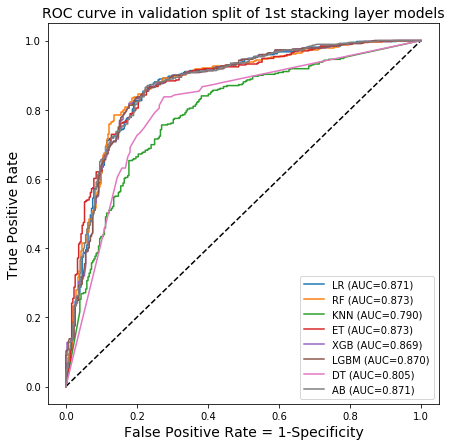

In [6]:
plt.figure(figsize=(7,7))
plt.plot([0,1],[0,1],'--',color='black')
plt.xlabel('False Positive Rate = 1-Specificity',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC curve in validation split of 1st stacking layer models',fontsize=14)

for model in models.keys():
    best_parametrization = grid[model][np.argmax(AUCs[model])]
    classifier = models[model](**best_parametrization)
    classifier.fit(x_train,y_train)
    pickle.dump(classifier,open('Data/model_layer1_'+model+'.dat','wb'))
    [fpr_validation,tpr_validation,thr_validation] = roc_curve(y_validation,classifier.predict_proba(x_validation)[:,1])
    plt.plot(fpr_validation,tpr_validation,label=model+' (AUC=%0.3f)'%auc(fpr_validation,tpr_validation))

plt.legend(loc='lower right')
InteractiveShell.ast_node_interactivity = 'all'